# How to predict CLTV for Shopify Stores with Machine Learning.

### Table of Contents: 

<br> **I. INTRODUCTION \& PRELIMINARY ANALYSIS**
- 1. Project Purpose 
- 2. Loading \& Previewing Data   
- 3. Data Wrangling  
- 4. Preliminary EDA 
 
**II. DATA WRANGLING**  
- 1. Cleaning up data. 
- 2. Creating 3 separate dataframes.
- 3. Creating the final 1 year CLTV Table.

**III. EXPLORATORY DATA ANALYSIS**     
- 1. Loading an Previewing the New Table  
- 2. Exploring relationships of variables on Post First Week Spend 

<font color='blue'>**IV. PREPROCESSING AND MODELLING** </font> 
- 1. Linear Models
- 2. Classification Models


### Part 3: PreProcessing and Modelling

### Loading our Packages and DataFrame

In [1]:
## We start by importing the appropriate packages which we will want to use. 
import warnings
from io import StringIO  
import pydotplus
import graphviz
from IPython.display import Image  

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from statsmodels.graphics.api import abline_plot 

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.tree import DecisionTreeRegressor,DecisionTreeClassifier,plot_tree,export_graphviz
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV

from sklearn.metrics import precision_recall_curve, roc_curve, auc, confusion_matrix, accuracy_score, precision_score
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, f1_score, fbeta_score, classification_report
from sklearn.metrics import plot_confusion_matrix , balanced_accuracy_score, recall_score

%matplotlib inline
pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')

In [2]:
## We Load and preview our customer_cltv dataframe from the previouse chapter 
customer_cltv = pd.read_csv('.\..\cleaned_data.csv',index_col=0)
customer_cltv.head()

,CustomerID,pfw_spent,fw_nb_orders,fw_nb_items,fw_total_spent,fw_used_coupon,first_order_month,fw_purchased_accessory,first_item_size,accepts_marketing,wealthy_zip,region,first_item_price_range
0,Anonymous13455,1257.80,1,1,50.0,0,6,0,M,0,0,MW,high
1,Anonymous2142,436.15,1,1,48.0,0,5,0,L,0,0,NE,high
2,Anonymous4843,1052.75,2,2,96.0,0,10,0,S,1,0,W,high
3,Anonymous11225,728.10,1,1,16.0,0,1,1,No size,0,0,MW,low
4,Anonymous540,1114.75,1,1,50.0,0,1,0,XS,0,0,W,high


## Preprocessing: 

In [3]:
## Drop some error rows (no spending on the first week)
customer_cltv_drop = customer_cltv[customer_cltv.loc[:,'fw_total_spent'] > 0] 

## Drop all non-repeat customers
#customer_cltv_drop = customer_cltv_drop[customer_cltv.loc[:,'pfw_spent'] > 0]

<br> **Drop vriables that we found to be heavily correlated with other or irrelevant through the previous step of EDA**
- fw_nb_items is highly correlated with fw_total_spent (c=0.94)
- fw_nb_orders is very unbalanced (~ 95% customers only made 1 order the first week)
- region was found to be insignificant based on several steps of statistical analysis
- fw_purchased_accessory is logically redundant with first_item_size


In [4]:
customer_cltv_drop.drop(columns=['fw_nb_items', 'region', 'fw_nb_orders', 'fw_purchased_accessory'], inplace = True)

<br> **Modify variables based on findings from EDA**
- first_order_month can be modified to be 2 categories: February-June vs rest of the year

In [5]:
customer_cltv_drop['first_order_feb_june'] = customer_cltv_drop['first_order_month'].apply(lambda x: x in [2, 3, 4, 5, 6])
customer_cltv_drop.drop(columns=['first_order_month'], inplace = True)

#### We create dummy variables for our categorical variables.

In [6]:
categorical_cols = ['first_item_size','first_item_price_range']
dummies_encoded = pd.get_dummies(customer_cltv_drop[categorical_cols].astype(str),drop_first=True)
customer_cltv_encoded = pd.concat([customer_cltv_drop,dummies_encoded], axis =1)
customer_cltv_encoded.drop(columns=['first_item_size','first_item_price_range'],
                   inplace = True)

## We preview our table
customer_cltv_encoded.head(5)

,CustomerID,pfw_spent,fw_total_spent,fw_used_coupon,accepts_marketing,wealthy_zip,first_order_feb_june,first_item_size_M,first_item_size_No size,first_item_size_S,first_item_size_XL,first_item_size_XS,first_item_price_range_low,first_item_price_range_medium
0,Anonymous13455,1257.80,50.0,0,0,0,True,1,0,0,0,0,0,0
1,Anonymous2142,436.15,48.0,0,0,0,True,0,0,0,0,0,0,0
2,Anonymous4843,1052.75,96.0,0,1,0,False,0,0,1,0,0,0,0
3,Anonymous11225,728.10,16.0,0,0,0,False,0,1,0,0,0,1,0
4,Anonymous540,1114.75,50.0,0,0,0,False,0,0,0,0,1,0,0


In [7]:
## We get our feature variables and target variables
X = customer_cltv_encoded.drop(columns=['CustomerID','pfw_spent'])
y = customer_cltv_encoded['pfw_spent']
print(X.shape, y.shape)

(10590, 12) (10590,)


In [8]:
## We use a scaler to scale the feature variables which are not categorical: 
cols_to_scale = ['fw_total_spent']
scaler = StandardScaler().fit(X[cols_to_scale])
X_scaled = scaler.transform(X[cols_to_scale])
for ind, col in enumerate(cols_to_scale):
    X[col] = X_scaled[:,ind]
X.head()

,fw_total_spent,fw_used_coupon,accepts_marketing,wealthy_zip,first_order_feb_june,first_item_size_M,first_item_size_No size,first_item_size_S,first_item_size_XL,first_item_size_XS,first_item_price_range_low,first_item_price_range_medium
0,-0.347324,0,0,0,True,1,0,0,0,0,0,0
1,-0.389530,0,0,0,True,0,0,0,0,0,0,0
2,0.623424,0,1,0,False,0,0,1,0,0,0,0
3,-1.064833,0,0,0,False,0,1,0,0,0,1,0
4,-0.347324,0,0,0,False,0,0,0,0,1,0,0


In [9]:
## We split our data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(7942, 12) (2648, 12) (7942,) (2648,)


## I. Linear Models: 
- Ordinary Linear Regression
- Lasso, Ridge Regression - tried but don't bring benefits compared to OLS, because we find reasonable coefficient values without applying penalization.
- Elastic Net - not tried, though we would expect the same as above.

- Decision Trees
- Random Forest
- GBM
- Light GBM
- XGboost
- Adaboost
- Neural Networks

## Multiple Linear Regression

In [10]:
## We instantiate the linear Regression model and fit to the training data. 
rModel = LinearRegression(normalize = False)
rModel.fit(X_train, y_train)

LinearRegression(normalize=False)

In [11]:
## We check R squared. 
print("R-squared on training data: ", rModel.score(X_train,y_train))
print("R-squared on test data: ", rModel.score(X_test,y_test))
print("Model coefficients: ", rModel.coef_)
print("Model intercept: ", rModel.intercept_)
print("Coef matrix rank: ", rModel.rank_)
print("Coef matrix singular values: ", rModel.singular_)

R-squared on training data:  0.047097923114843065
R-squared on test data:  0.03728836133894331
Model coefficients:  [ 16.37223432   2.81381363   7.5793226   -5.38992058  13.73370418
  -8.71933939 -11.79505585 -12.20649571   3.14884656 -12.55414936
  -1.83364948  -2.6997442 ]
Model intercept:  39.15268541847427
Coef matrix rank:  12
Coef matrix singular values:  [90.79428893 50.60862309 46.45052426 44.25331612 39.11514057 34.20564871
 32.20886641 31.62877756 31.09081932 24.6293075  20.09019577 12.90283844]


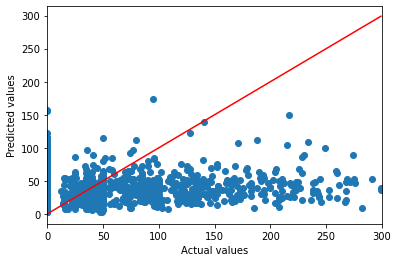

In [12]:
## We visualize the actual values vs the predicted values. 
y_pred = rModel.predict(X_test)
plt.scatter(y_test, y_pred)
plt.xlabel('Actual values')
plt.ylabel('Predicted values')
plt.plot([x for x in range(0,300)],[x for x in range(0,300)], color='r')
plt.xlim(0,300)
plt.show()

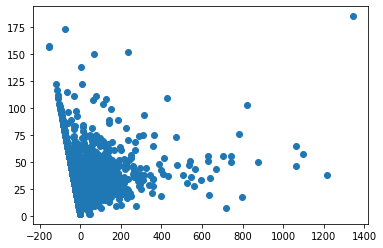

In [13]:
## Plotting Residuals
residuals = y_test - y_pred
plt.scatter(residuals,y_pred)
plt.show()

## Random Forest Regressor

In [14]:
## We instantiate a Random Forest Regressor and fit it to the training and testing data. We loo
rfg = RandomForestRegressor(n_estimators=100, max_depth=6)
rfg.fit(X_train,y_train)
print("R squared for random forest regressor, on training data: ", rfg.score(X_train, y_train))
print("R squared for random forest regressor, on test data: ", rfg.score(X_test, y_test))

R squared for random forest regressor, on training data:  0.13730960254500812
R squared for random forest regressor, on test data:  0.02672392460204842


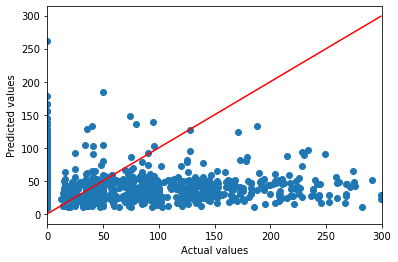

In [15]:
y_pred = rfg.predict(X_test)
plt.scatter(y_test, y_pred)
plt.xlabel('Actual values')
plt.ylabel('Predicted values')
plt.plot([x for x in range(0,300)],[x for x in range(0,300)], color='r')
plt.xlim(0,300)
plt.show()

## 2. Classification Models
- In the previous models, our target feature was **continuous**. We will be t

In [16]:
## We remind ourselves the percentage of people who did make a purchase past the first week
customer_cltv_drop[customer_cltv_drop['pfw_spent'] > 0]['pfw_spent'].count() / customer_cltv_drop['pfw_spent'].count()

0.2715769593956563

In [17]:
## We create a new table and add a new target variable: pfw_return
customer_cltv_cls = customer_cltv_drop
customer_cltv_cls['pfw_return'] = np.where(customer_cltv_cls['pfw_spent'] > 0,1,0)

## We recreate the dummy variables and drop the original columns
categorical_cols = ['first_item_size','first_item_price_range']
dummies_encoded = pd.get_dummies(customer_cltv_cls[categorical_cols].astype(str),drop_first=True)
customer_cltv_encoded = pd.concat([customer_cltv_cls,dummies_encoded], axis =1)
customer_cltv_encoded.drop(columns=['first_item_size','first_item_price_range','pfw_spent'],inplace = True)

## We preview the amount of post first week customers and the first few rows of our new dataframe.
print(customer_cltv_encoded.pfw_return.value_counts())
customer_cltv_encoded.head()

0    7714
1    2876
Name: pfw_return, dtype: int64


,CustomerID,fw_total_spent,fw_used_coupon,accepts_marketing,wealthy_zip,first_order_feb_june,pfw_return,first_item_size_M,first_item_size_No size,first_item_size_S,first_item_size_XL,first_item_size_XS,first_item_price_range_low,first_item_price_range_medium
0,Anonymous13455,50.0,0,0,0,True,1,1,0,0,0,0,0,0
1,Anonymous2142,48.0,0,0,0,True,1,0,0,0,0,0,0,0
2,Anonymous4843,96.0,0,1,0,False,1,0,0,1,0,0,0,0
3,Anonymous11225,16.0,0,0,0,False,1,0,1,0,0,0,1,0
4,Anonymous540,50.0,0,0,0,False,1,0,0,0,0,1,0,0


In [18]:
## We recreate our target and feature variables which we will feed into different models and print their shape.
X = customer_cltv_encoded.drop(columns=['CustomerID','pfw_return'])
y = customer_cltv_encoded['pfw_return']
print(X.shape,y.shape)

(10590, 12) (10590,)


In [19]:
## We split the data in training and testing sets.
X_train, X_test , y_train, y_test = train_test_split(X,y, test_size =0.25, random_state =1234)
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

(7942, 12) (2648, 12) (7942,) (2648,)


## Logistic Regression 

In [20]:
## We instantiate a logistic regression model and use GridSearchCV to find the best parameters. 
'''
log_reg = LogisticRegression()
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
             'l1_ratio': [0,.5,1]
             }
lr_cv = GridSearchCV(log_reg, param_grid, cv=10, scoring='roc_auc')
lr_cv.fit(X,y)
lr_cv.best_estimator_
'''
# We get the result: 'LogisticRegression(C=10, l1_ratio=0) '

"\nlog_reg = LogisticRegression()\nparam_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],\n             'l1_ratio': [0,.5,1]\n             }\nlr_cv = GridSearchCV(log_reg, param_grid, cv=10, scoring='roc_auc')\nlr_cv.fit(X,y)\nlr_cv.best_estimator_\n"

In [21]:
## With the best parameters, we re-instantiate the model, fit and predict the probabilities. 
log_reg = LogisticRegression(C=10)
log_reg.fit(X_train, y_train)

## We predict the probabilities of s
y_pred = log_reg.predict(X_test)
y_pred = pd.Series(y_pred)

## We visualize the prediction that the Logistic Regression Gives us. 
y_pred.value_counts()

0    2632
1      16
dtype: int64

In [22]:
y_pred = log_reg.predict_proba(X_test)[:,1]
log_fpr, log_tpr, threshold = roc_curve(y_test,y_pred)
log_auc = auc(log_fpr, log_tpr)
print(log_auc)

0.5898561093549088


## Decision Tree 

In [23]:
# We instantiate a Decision Tree Classifier it and fit to training data, then predict on testing data.
dt = DecisionTreeClassifier(criterion ='entropy', max_depth = 5, random_state=1234)
dt.fit(X_train, y_train) 
y_pred = dt.predict(X_test)
y_pred = pd.Series(y_pred)

## We visualize the predictions of pfw and 
y_pred.value_counts()

0    2640
1       8
dtype: int64

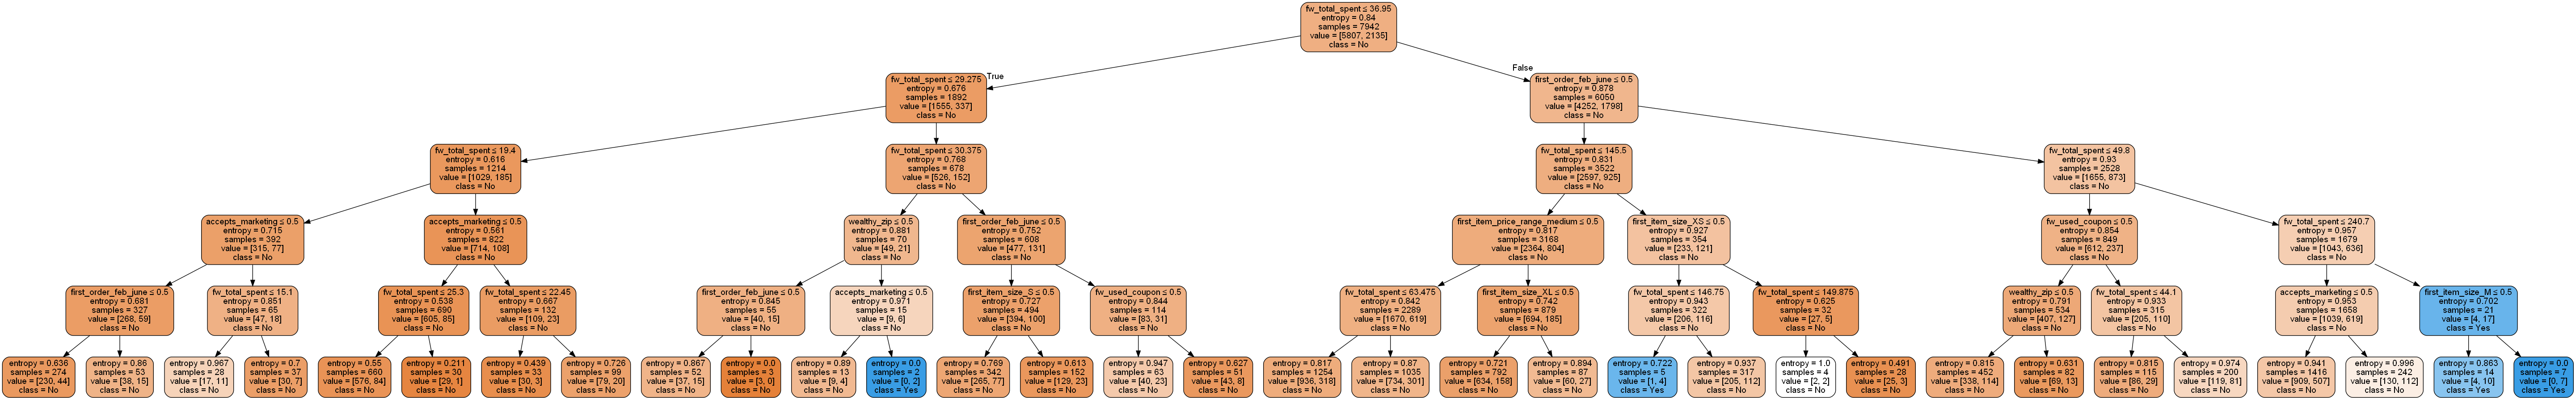

In [24]:
# Now we want to visualize the tree
dot_data = StringIO()

# We can do so with export_graphviz
export_graphviz(dt, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True, feature_names=X_train.columns,class_names = ["No", "Yes"]) 

# Alternatively for class_names use entr_model.classes_
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

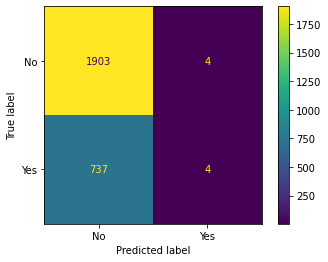

In [25]:
## We can plot a confusion matrix
plot_confusion_matrix(dt,X_test,y_test, display_labels=['No','Yes'])
plt.show()

In [26]:
# Run this block for model evaluation
print("Model Gini impurity model")
print("Accuracy:", accuracy_score(y_test,y_pred))
print("Balanced accuracy:", balanced_accuracy_score(y_test,y_pred))
print('Precision score' , precision_score(y_test,y_pred, pos_label = 1))
print('Recall score' , recall_score(y_test,y_pred, pos_label = 0))

Model Gini impurity model
Accuracy: 0.720166163141994
Balanced accuracy: 0.5016502876326794
Precision score 0.5
Recall score 0.9979024646040902


## Random Forests:

In [27]:
# We instantiate the RandomForestClassifier and use GridSearch for best hyperparameters
'''
rfc = RandomForestClassifier(random_state = 1234)
param_grid = { 
    'n_estimators': [10, 25, 50, 75, 100],
    'max_features': [None, 'auto', 'log2'],
    'max_depth' : list(range(0,10)),
}
rfc_cv = GridSearchCV(rfc, param_grid, cv=10, scoring='roc_auc')

rfc_cv.fit(X,y)
rfc_cv.best_estimator_
'''
## The findings for the above cell (if all customers) is: ' RandomForestClassifier(max_depth=4, n_estimators=10) '
## The findings for the above cell (if pfw > 0 ) is: ' RandomForestClassifier(max_depth=10, n_estimators=25) '

"\nrfc = RandomForestClassifier(random_state = 1234)\nparam_grid = { \n    'n_estimators': [10, 25, 50, 75, 100],\n    'max_features': [None, 'auto', 'log2'],\n    'max_depth' : list(range(0,10)),\n}\nrfc_cv = GridSearchCV(rfc, param_grid, cv=10, scoring='roc_auc')\n\nrfc_cv.fit(X,y)\nrfc_cv.best_estimator_\n"

In [28]:
## We now fit the RF
rfc = RandomForestClassifier(max_depth=4, n_estimators=10)
rfc.fit(X_train, y_train)
y_pred = rfc.predict_proba(X_test)[:,1]
y_predict = rfc.predict(X_test)
y_predict

array([0, 0, 0, ..., 0, 0, 0])

RF model - max depth 3
Accuracy: 0.720166163141994
Balanced accuracy: 0.5
Precision score 0.0
Recall score 1.0


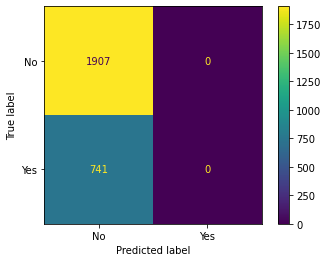

In [29]:
# Model and fit
y_pred = rfc.predict(X_test)
y_pred = pd.Series(y_pred)

# Metrics 
print("RF model - max depth 3")
print("Accuracy:", accuracy_score(y_test,y_predict))
print("Balanced accuracy:", balanced_accuracy_score(y_test,y_predict))
print('Precision score' , precision_score(y_test,y_predict, pos_label = 1))
print('Recall score' , recall_score(y_test,y_predict, pos_label = 0))
plot_confusion_matrix(rfc,X_test,y_test, display_labels=['No','Yes'])
plt.show()

In [30]:
rfc_fpr, rfc_tpr, threshold = roc_curve(y_test, y_pred)
auc_rfc = auc(rfc_fpr, rfc_tpr)
print(auc_rfc)

0.5


In [31]:
## We visualize the feature importance for the Random Forest Model
fi_rfc = pd.DataFrame(rfc.feature_importances_, index = X_train.columns, 
                      columns=['importance']).sort_values('importance', ascending=False)
fi_rfc

,importance
fw_total_spent,0.435255
first_order_feb_june,0.170278
first_item_size_No size,0.161735
accepts_marketing,0.055030
first_item_price_range_low,0.044810
first_item_price_range_medium,0.029352
first_item_size_XS,0.021137
wealthy_zip,0.019361
fw_used_coupon,0.017211
first_item_size_XL,0.016306


In [32]:
fi_rfc.reset_index(inplace=True)
fi_rfc

,index,importance
0,fw_total_spent,0.435255
1,first_order_feb_june,0.170278
2,first_item_size_No size,0.161735
3,accepts_marketing,0.055030
4,first_item_price_range_low,0.044810
5,first_item_price_range_medium,0.029352
6,first_item_size_XS,0.021137
7,wealthy_zip,0.019361
8,fw_used_coupon,0.017211
9,first_item_size_XL,0.016306


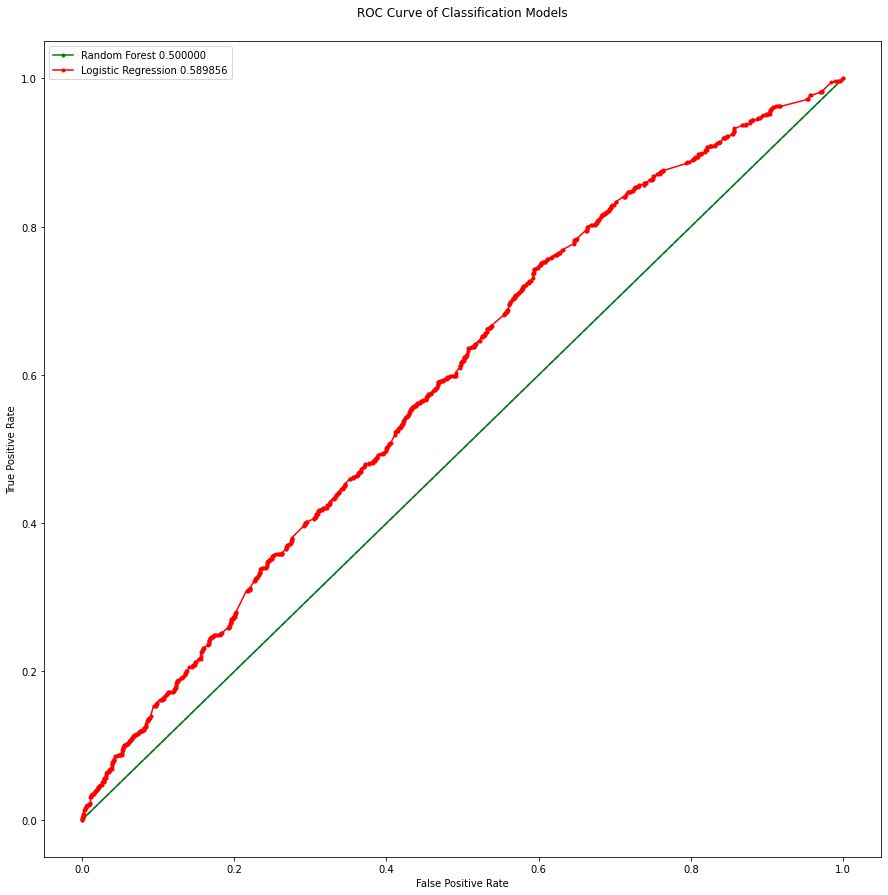

In [33]:
## We plot the ROC and visualize the AUC of our classification models
fig, heat = plt.subplots(figsize = (15,15))
plt.plot(rfc_fpr, rfc_tpr, marker='.', color='green', label='Random Forest %f' % auc_rfc)
plt.plot(log_fpr, log_tpr, marker='.', color='red', label='Logistic Regression %f' % log_auc)

# We plot a line that goes shows when FPR = TPR
lims = [np.min([0.0, 0.0]),  
        np.max([1.0, 1.0])]
plt.plot(lims, lims, 'k-', alpha=0.75, zorder=0, c='b', linestyle ='--')

## We label the axes and give a title. 
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve of Classification Models', pad =25)
plt.legend()
plt.savefig('auc_comp.png')
plt.show()